In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

## Two machine learning models to predict housing prices using data from real estate sales, a neural network followed by a random forest

In [2]:
# import data
# create an SQLite database engine named "database.db"
engine = create_engine("sqlite:///resources/database.db")

# query the database to verify the insertion
query = "SELECT * FROM houses"
df = pd.read_sql(query, engine)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [4]:
# fill missing values with the mean for each numerical feature
print("Numerical data columns with null values before filling with mean:")
print(df_num[df_num.columns[df_num.isnull().any()]].isnull().sum())

df = df.fillna(df_num.mean())

print("All columns with null values after filling with mean (check vs above):")
print(df[df.columns[df.isnull().any()]].isnull().sum())

Numerical data columns with null values before filling with mean:
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
All columns with null values after filling with mean (check vs above):
Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [5]:
# drop 'Id', as it does not matter
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [6]:
# drop outliers (rooms with more than 4000 square feet)
print(len(df))
df = df[df.GrLivArea <= 4000]
print(len(df))

1460
1456


In [7]:
# feature engineer new series
df["TotalLivArea"] = df.GrLivArea + df.TotalBsmtSF - df.BsmtUnfSF

In [8]:
# feature engineer new room metric
df["TotalRooms"] = (
    df.BedroomAbvGr
    + df.KitchenAbvGr
    + df.FullBath
    + df.HalfBath
    + df.BsmtFullBath
    + df.BsmtHalfBath
)

In [9]:
# redefine the df to contain only target variables
df = df[
    [
        "OverallQual",
        "OverallCond",
        "TotalLivArea",
        "TotalRooms",
        "YearBuilt",
        "SaleCondition",
        "Neighborhood",
        "SalePrice",
    ]
]
df.head()

,OverallQual,OverallCond,TotalLivArea,TotalRooms,YearBuilt,SaleCondition,Neighborhood,SalePrice
0,7,5,2416,8,2003,Normal,CollgCr,208500
1,6,8,2240,7,1976,Normal,Veenker,181500
2,7,5,2272,8,2001,Normal,CollgCr,223500
3,7,5,1933,6,1915,Abnorml,Crawfor,140000
4,8,5,2853,9,2000,Normal,NoRidge,250000


In [10]:
# drop Blueste Neighborhood (which has only two values and a weird outlier)
print(len(df))
df.drop(df[df["Neighborhood"] == "Blueste"].index, inplace=True)
print(len(df))

1456
1454


In [11]:
# check Neighborhood value_counts for binning
df.Neighborhood.value_counts()

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     39
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Name: count, dtype: int64

In [12]:
# bin small neighborhoods
neighborhood_cutoff = 50
neighborhood_counts = df.Neighborhood.value_counts()
Neighborhoods_to_replace = neighborhood_counts[
    neighborhood_counts < neighborhood_cutoff
].index

# loop to replace in df
for neighborhood in Neighborhoods_to_replace:
    df["Neighborhood"] = df.Neighborhood.replace(neighborhood, "Other")

# check that binning was successful
df.Neighborhood.value_counts()

Neighborhood
Other      311
NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Name: count, dtype: int64

In [13]:
# drop unusual sale conditions
print(len(df))
df = df[df["SaleCondition"] == "Normal"]
print(len(df))

1454
1195


In [14]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,OverallQual,OverallCond,TotalLivArea,TotalRooms,YearBuilt,SalePrice,SaleCondition_Normal,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst
0,7,5,2416,8,2003,208500,True,False,True,False,False,False,False,False,False,False,False,False,False,False
1,6,8,2240,7,1976,181500,True,False,False,False,False,False,False,False,False,False,True,False,False,False
2,7,5,2272,8,2001,223500,True,False,True,False,False,False,False,False,False,False,False,False,False,False
4,8,5,2853,9,2000,250000,True,False,False,False,False,False,False,False,False,False,True,False,False,False
5,5,5,2094,5,1993,143000,True,False,False,False,False,False,False,False,False,False,True,False,False,False


SalePrice               1.000000
OverallQual             0.792207
TotalLivArea            0.771283
TotalRooms              0.505795
YearBuilt               0.504184
Neighborhood_NridgHt    0.322167
Neighborhood_Other      0.136565
Neighborhood_Somerst    0.131268
Neighborhood_CollgCr    0.098121
Neighborhood_Crawfor    0.085845
Neighborhood_NWAmes     0.066824
Neighborhood_SawyerW    0.051623
Neighborhood_Gilbert    0.051341
OverallCond            -0.050749
Neighborhood_Sawyer    -0.136080
Neighborhood_BrkSide   -0.158061
Neighborhood_NAmes     -0.179340
Neighborhood_OldTown   -0.179561
Neighborhood_Edwards   -0.188333
SaleCondition_Normal         NaN
Name: SalePrice, dtype: float64


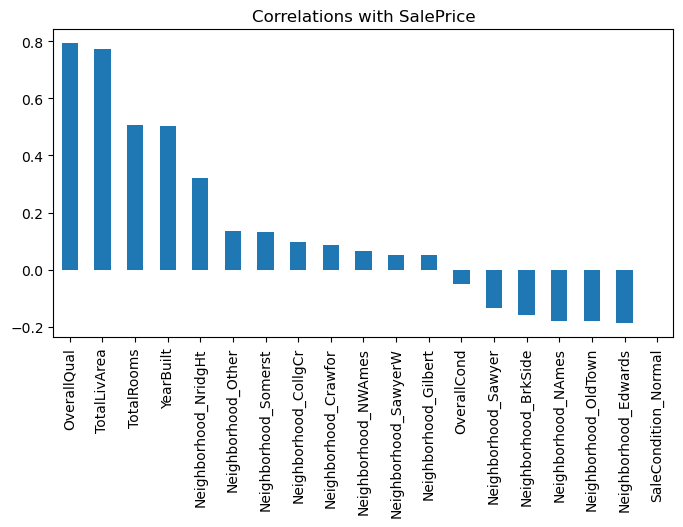

<Figure size 4000x1000 with 0 Axes>

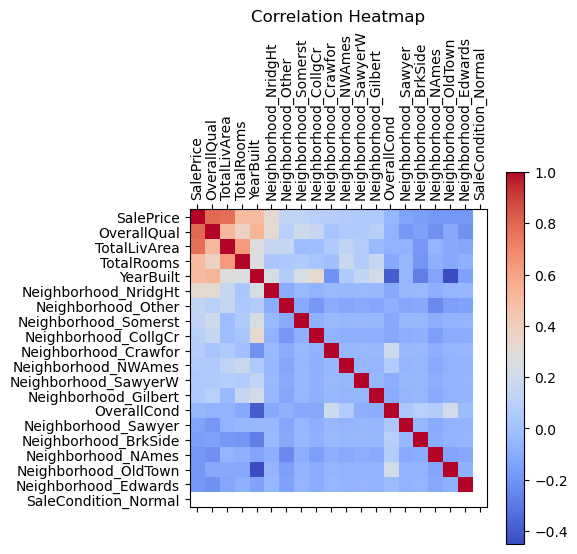

In [15]:
# calculate correlations, print and plot (bar chart and heatmap)
correlations = dummies.corr()["SalePrice"].sort_values(ascending=False)

# print correlations
print(correlations)

# plot correlations bar chart
plt.figure(figsize=(8, 4))
correlations.drop("SalePrice").plot(kind="bar")
plt.title("Correlations with SalePrice")
# save image
plt.savefig("images/correlation_bar.png")
plt.show()

# convert correlations to a DataFrame for the heatmap
correlations_df = dummies[correlations.index].corr()

# plot a heatmap of correlations
plt.figure(figsize=(40, 10))
plt.matshow(correlations_df, cmap="coolwarm")
plt.xticks(range(len(correlations_df.columns)), correlations_df.columns, rotation=90)
plt.yticks(range(len(correlations_df.columns)), correlations_df.columns)
plt.colorbar()
plt.title("Correlation Heatmap")
# save image
plt.savefig("images/correlation_heatmap.png")
plt.show()

In [16]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
# validation data is used to course correct the model throughout the epochs
# it helps prevent overfitting before the final model is run against the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage
# computes the mean and standard deviation need for scaling
# (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

# transform the data with the fit
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Compile, Train, and Evaluate the Neural Network

In [17]:
# build neural network
nn = tf.keras.models.Sequential()

# build neural network using our testing results
parameters = {
    "num_layers": 4,
    "layer0": 334,
    "activation0": "relu",
    "layer1": 398,
    "activation1": "relu",
    "layer2": 120,
    "activation2": "relu",
    "layer3": 58,
    "activation3": "relu",
}

# loop to build nn using our parameters
# save activation function name for nn.summary()
for i in range(parameters["num_layers"]):
    layer_units = parameters[f"layer{i}"]
    activation_function = parameters[f"activation{i}"]

    nn.add(
        tf.keras.layers.Dense(
            units=layer_units,
            activation=activation_function,
            name=f"dense_{i}_{activation_function}",
        )
    )

# add final layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear", name="output_linear"))

In [18]:
# compile the model
nn.compile(
    loss="mean_absolute_error",
    optimizer="adam",
    metrics=["mae"],
)

In [19]:
# add early stopping to prevent overfitting
# rolls back the epochs if validation loss shows overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/100


28/28 [==============================] - 2s 12ms/step - loss: 176363.9688 - mae: 176363.9688 - val_loss: 163928.5781 - val_mae: 163928.5781
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 175340.3906 - mae: 175340.3906 - val_loss: 160639.8125 - val_mae: 160639.8125
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 163918.4844 - mae: 163918.4844 - val_loss: 132809.9688 - val_mae: 132809.9688
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 103702.1172 - mae: 103702.1172 - val_loss: 48321.3359 - val_mae: 48321.3359
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 33971.0898 - mae: 33971.0898 - val_loss: 23945.4844 - val_mae: 23945.4844
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 22092.2090 - mae: 22092.2090 - val_loss: 19799.0996 - val_mae: 19799.0996
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 19860.1543 - mae: 19860.1543

In [20]:
# summary of results
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0_relu (Dense)        (None, 334)               6680      
                                                                 
 dense_1_relu (Dense)        (None, 398)               133330    
                                                                 
 dense_2_relu (Dense)        (None, 120)               47880     
                                                                 
 dense_3_relu (Dense)        (None, 58)                7018      
                                                                 
 output_linear (Dense)       (None, 1)                 59        
                                                                 
Total params: 194967 (761.59 KB)
Trainable params: 194967 (761.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# print weights
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[ 0.30481502 -0.00655222  0.43235436 ... -0.24102613 -0.17777623
   0.03396116]
 [ 0.05898095  0.05941699  0.00809945 ...  0.20673187  0.16065887
  -0.15083149]
 [ 0.30690002  0.12137041  0.23842964 ... -0.0174608  -0.08289268
   0.13822089]
 ...
 [ 0.20957473 -0.19418092  0.22840749 ...  0.17741136  0.06494893
   0.20680062]
 [ 0.14696169 -0.28635526  0.05423687 ... -0.04197456 -0.26352853
  -0.2721175 ]
 [ 0.16980481 -0.17111202  0.16288869 ... -0.16061677 -0.29994345
   0.11052149]]
Layer 1 Weights:
[0.24374525 0.16321404 0.16554648 0.22142643 0.16681306 0.14530127
 0.16878627 0.14057223 0.2014394  0.17232469 0.15701875 0.14685263
 0.20322749 0.1875262  0.25667897 0.191471   0.14002481 0.21632485
 0.17599788 0.20109554 0.16413039 0.23765267 0.20320776 0.2000865
 0.13105373 0.12892267 0.18264922 0.15444843 0.21272555 0.2416983
 0.17506528 0.23274744 0.15459312 0.18383111 0.18146719 0.13744023
 0.20302747 0.16613674 0.16521038 0.128932   0.17417449 0.17633477
 0.2260

In [22]:
# revert scaled data for testing predictions
y_test_pred = nn.predict(X_test)

5/5 [==============================] - 0s 2ms/step


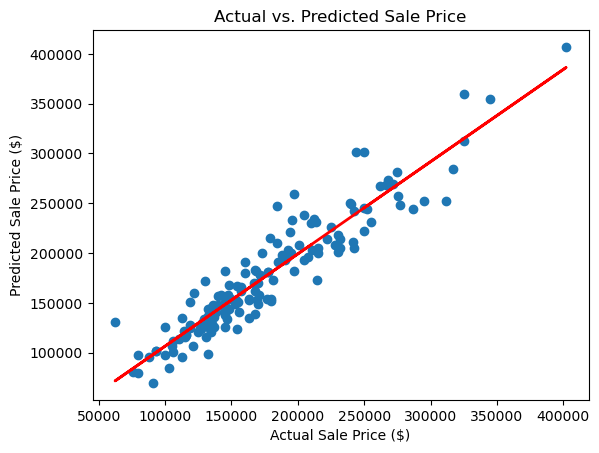

In [23]:
# scatter plot for actual vs. predicted SalePrice
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.title("Actual vs. Predicted Sale Price")

# add line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

# save image
plt.savefig("images/nn_scatter.png")

plt.show()

In [24]:
# print the r_squared and other metrics
print(
    f"""R-squared: {r2_score(y_test, y_test_pred)}
Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}
Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}
Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}"""
)

R-squared: 0.8781233961368512
Mean Squared Error: 446280152.9154423
Mean Absolute Error: 15541.401302083334
Mean Percentage Error: -12.6439235740575


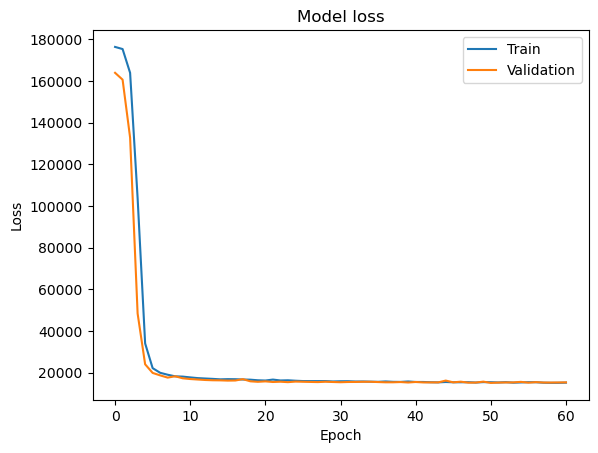

In [25]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
# save image
plt.savefig("images/nn_loss.png")
plt.show()

5/5 [==============================] - 0s 2ms/step


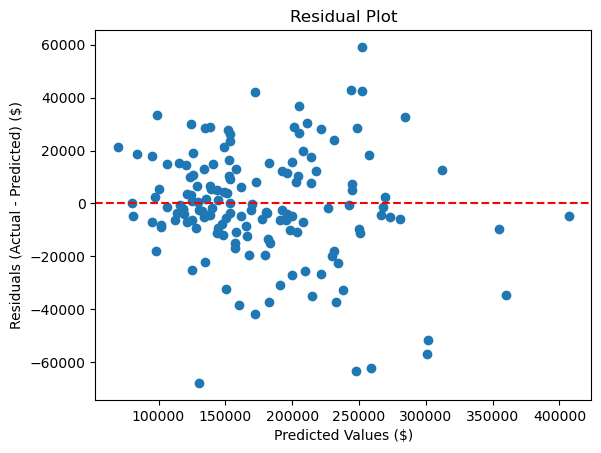

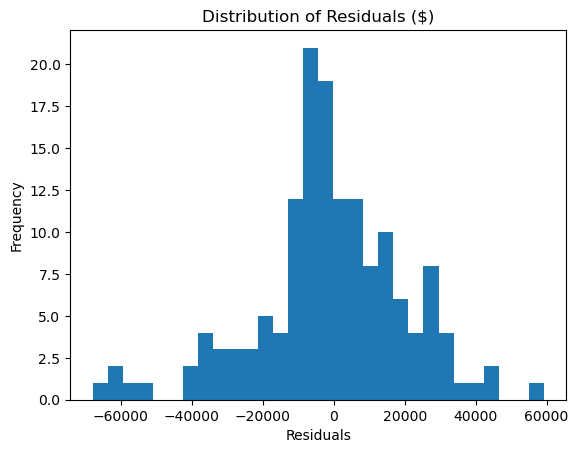

In [26]:
# plot residuals
# difference between actual and predicted values
# you want there to be a random distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()

plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values ($)")
plt.ylabel("Residuals (Actual - Predicted) ($)")
plt.title("Residual Plot")
# save image
plt.savefig("images/nn_residuals.png")
plt.show()

# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals ($)")
# save image
plt.savefig("images/nn_residuals_hist.png")
plt.show()

## Run and Evaluate Random Forest Model

In [27]:
# create random forest model
rf = RandomForestRegressor(random_state=42)

# train random forest model
rf.fit(X_train, y_train)

# predict
y_test_pred_rf = rf.predict(X_test)

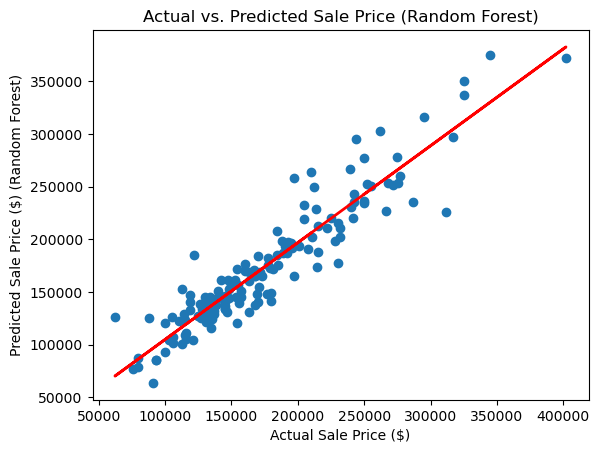

In [28]:
# scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred_rf)
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($) (Random Forest)")
plt.title("Actual vs. Predicted Sale Price (Random Forest)")

# add line of best fit
fit_rf = np.polyfit(y_test, y_test_pred_rf, 1)
line_rf = np.poly1d(fit_rf)
plt.plot(y_test, line_rf(y_test), color="red", linewidth=2)

# save image
plt.savefig("images/rf_scatter.png")

plt.show()

In [29]:
# r-squared and other metrics for Random Forest
print(
    f"""Random Forest R-squared: {r2_score(y_test, y_test_pred_rf)}
Random Forest Mean Squared Error: {mean_squared_error(y_test, y_test_pred_rf)}
Random Forest Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_rf)}
Random Forest Mean Percentage Error: {np.mean((y_test - y_test_pred_rf) / y_test) * 100}"""
)

Random Forest R-squared: 0.8716901201899889
Random Forest Mean Squared Error: 469837121.868538
Random Forest Mean Absolute Error: 15595.604066666669
Random Forest Mean Percentage Error: -0.48267727932113247


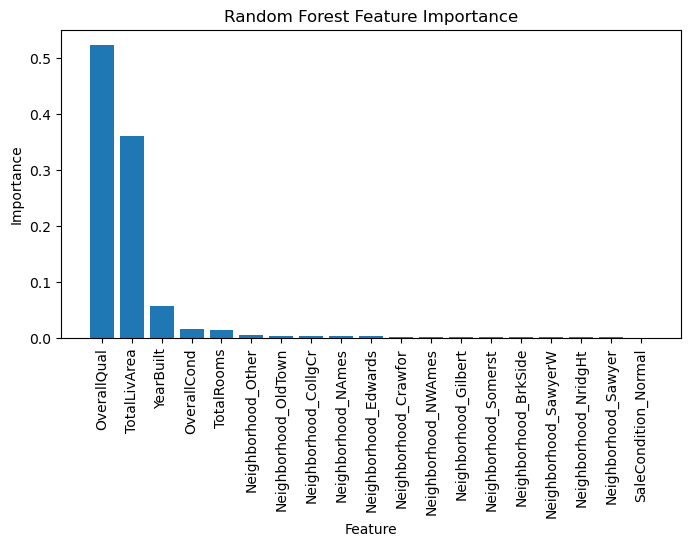

In [30]:
# plot random forest features
feature_importances = rf.feature_importances_

# cdreat df with feature names and importance scores
feature_importance_df = pd.DataFrame(
    {
        "Feature": dummies.drop(columns="SalePrice").columns,
        "Importance": feature_importances,
    }
)

# sort in descending order
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# plot
plt.figure(figsize=(8, 4))
plt.bar(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")

# save image
plt.savefig("images/rf_features.png")

plt.show()

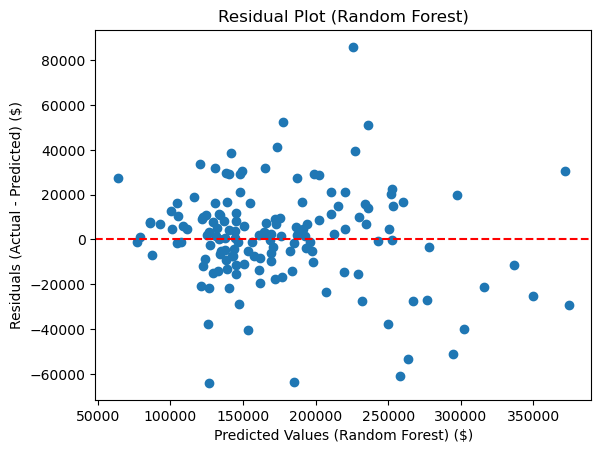

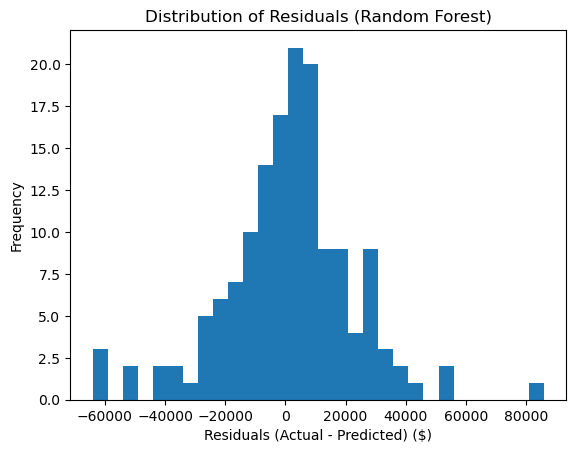

In [31]:
# plot residuals for Random Forest
residuals_rf = y_test - y_test_pred_rf

# scatter plot for residuals
plt.scatter(y_test_pred_rf, residuals_rf)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values (Random Forest) ($)")
plt.ylabel("Residuals (Actual - Predicted) ($)")
plt.title("Residual Plot (Random Forest)")
# save image
plt.savefig("images/rf_residuals.png")
plt.show()

# distribution of residuals
plt.hist(residuals_rf, bins=30)
plt.xlabel("Residuals (Actual - Predicted) ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Random Forest)")
# save image
plt.savefig("images/rf_residuals_hist.png")
plt.show()